In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
# from IPython.display import display, Latex

# Data Import

In [2]:
data = pd.read_excel("Data Cleaned.xlsx")
data.columns = ['', 'Operational Cost', 'Profit', 'Revenue', 'EPS']

__Variables__

In [3]:
dataProfit = pd.DataFrame(data.Profit)
dataOC = pd.DataFrame(data["Operational Cost"])
dataRev = pd.DataFrame(data.Revenue)
dataEPS = pd.DataFrame(data.EPS)

In [4]:
for x in [dataProfit, dataOC, dataEPS, dataRev]:
    x["AvgMean(2)"] = x.iloc[:,0].rolling(2).mean()
    x["AvgMean(4)"] = x.iloc[:,0].rolling(4).mean()

## Regression and Graphs

Trend Line Equation for EPS:	-0.01x + 0.46 
Trend Line Equation for Operational Cost:	-16.52x + 2912.02 
Trend Line Equation for Profit:	-48.22x + 1848.41 
Trend Line Equation for Revenue:	48.65x + 35983.84 


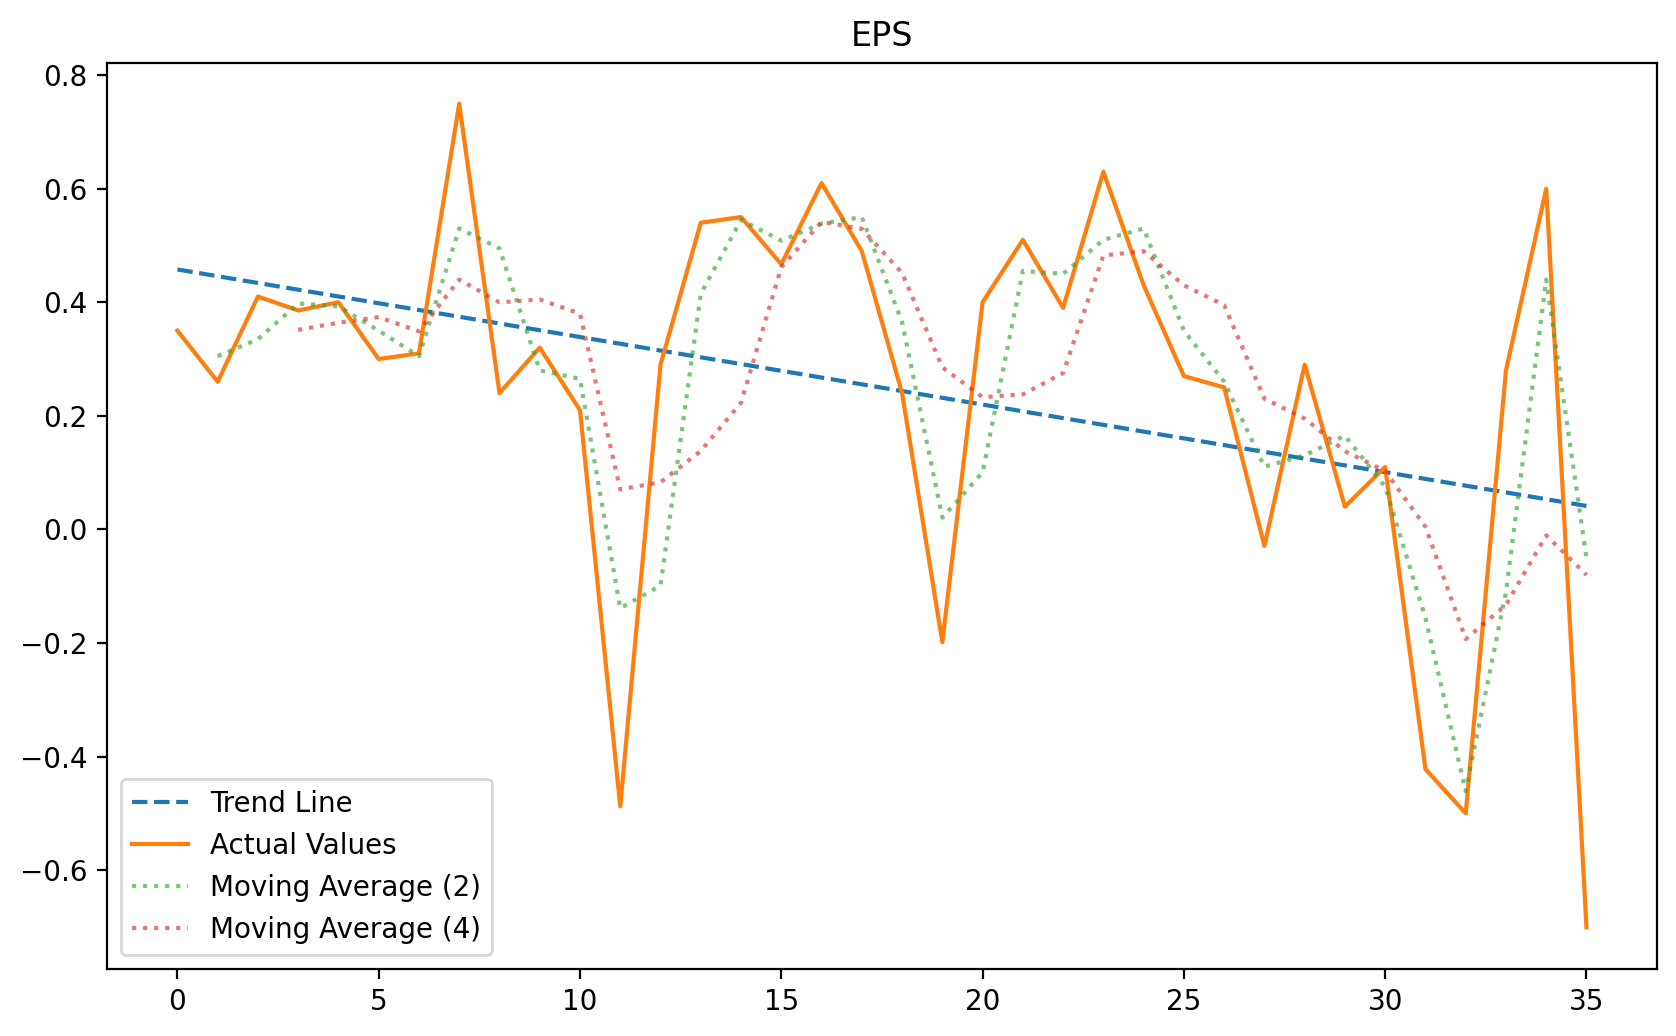

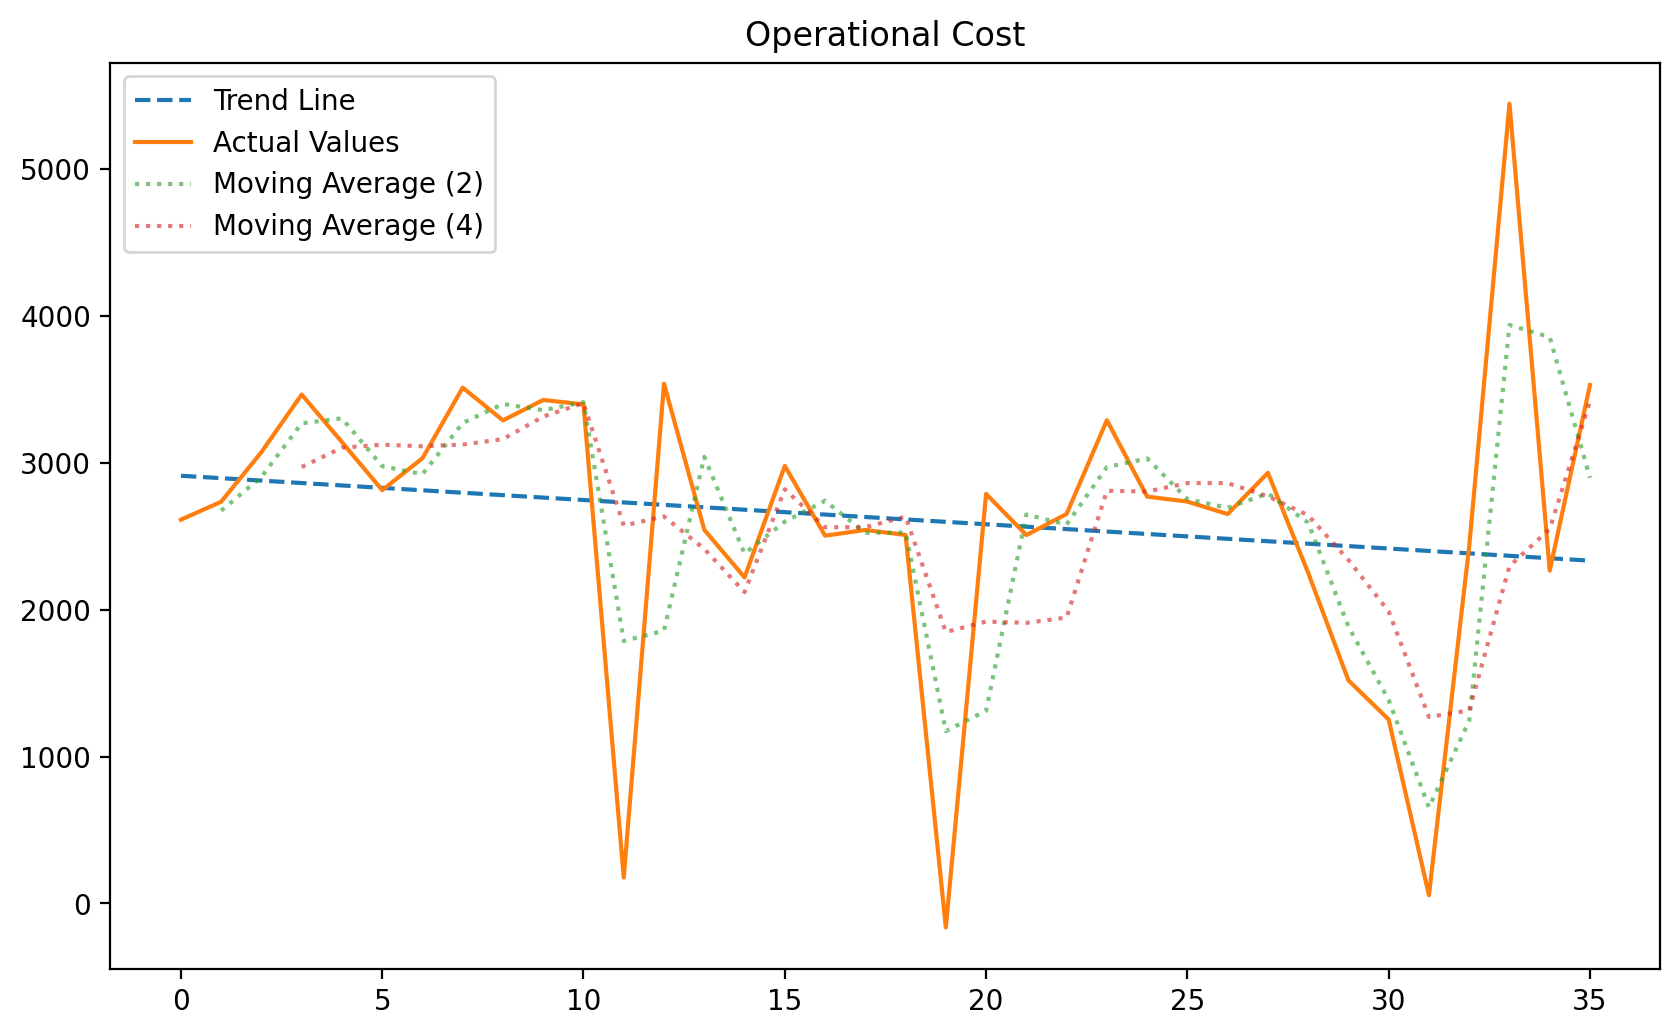

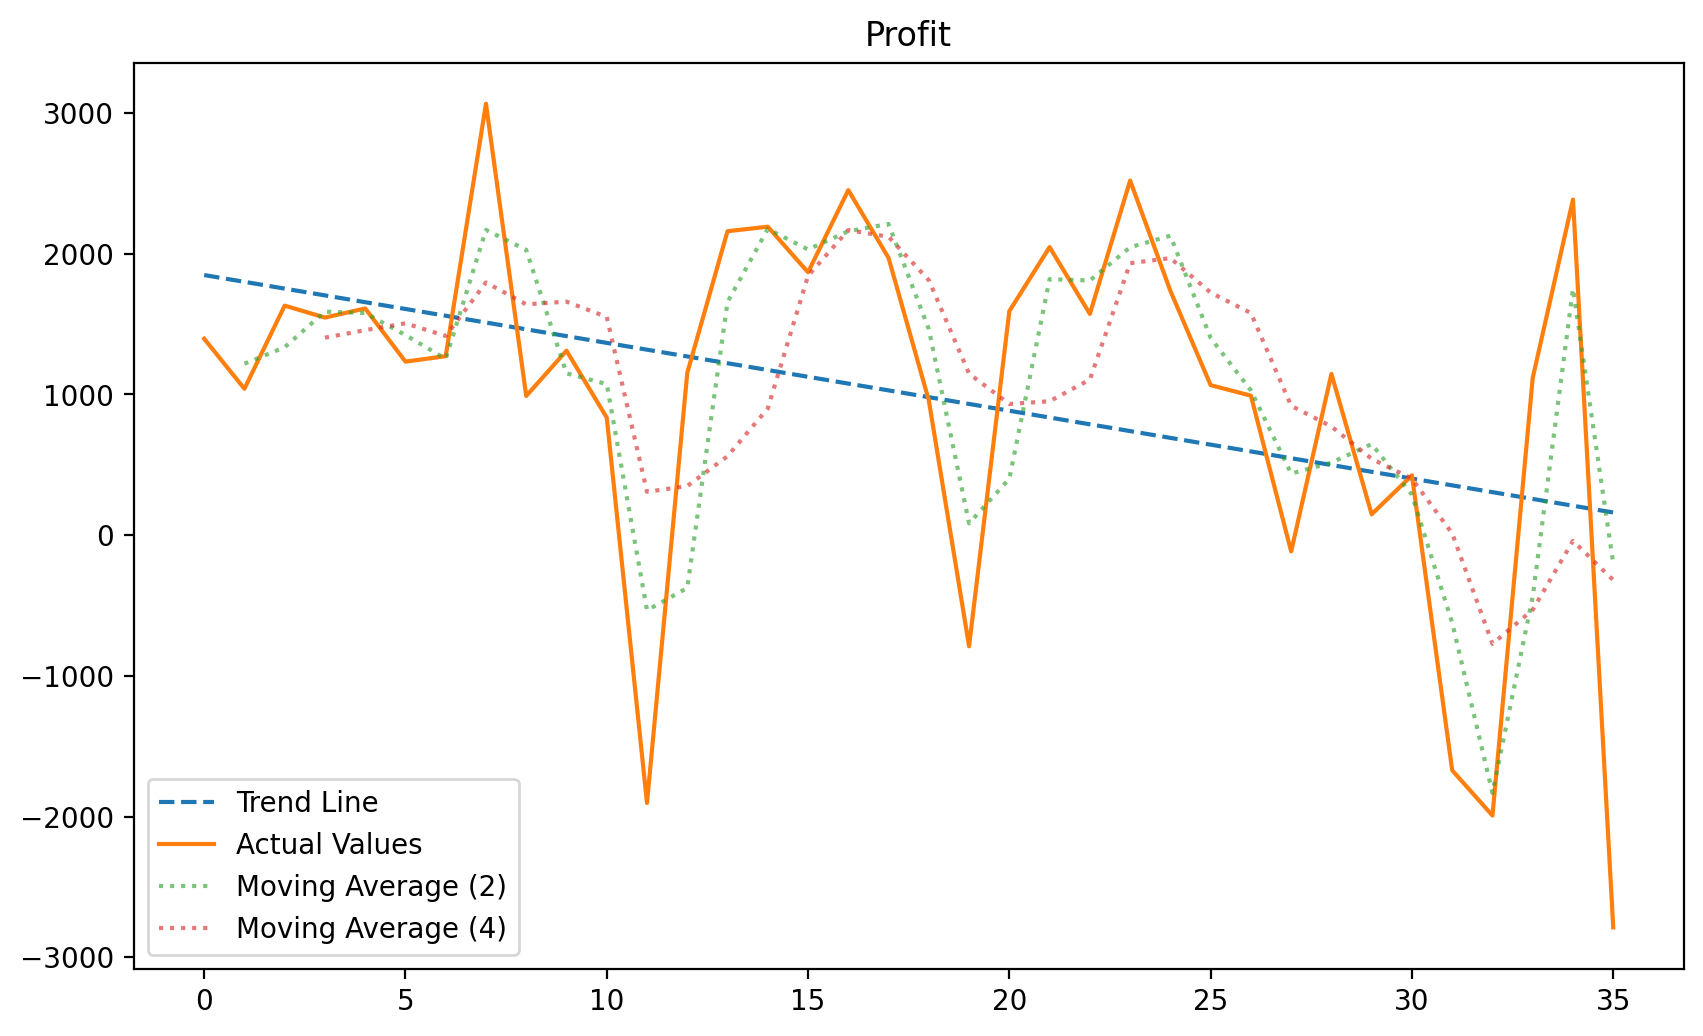

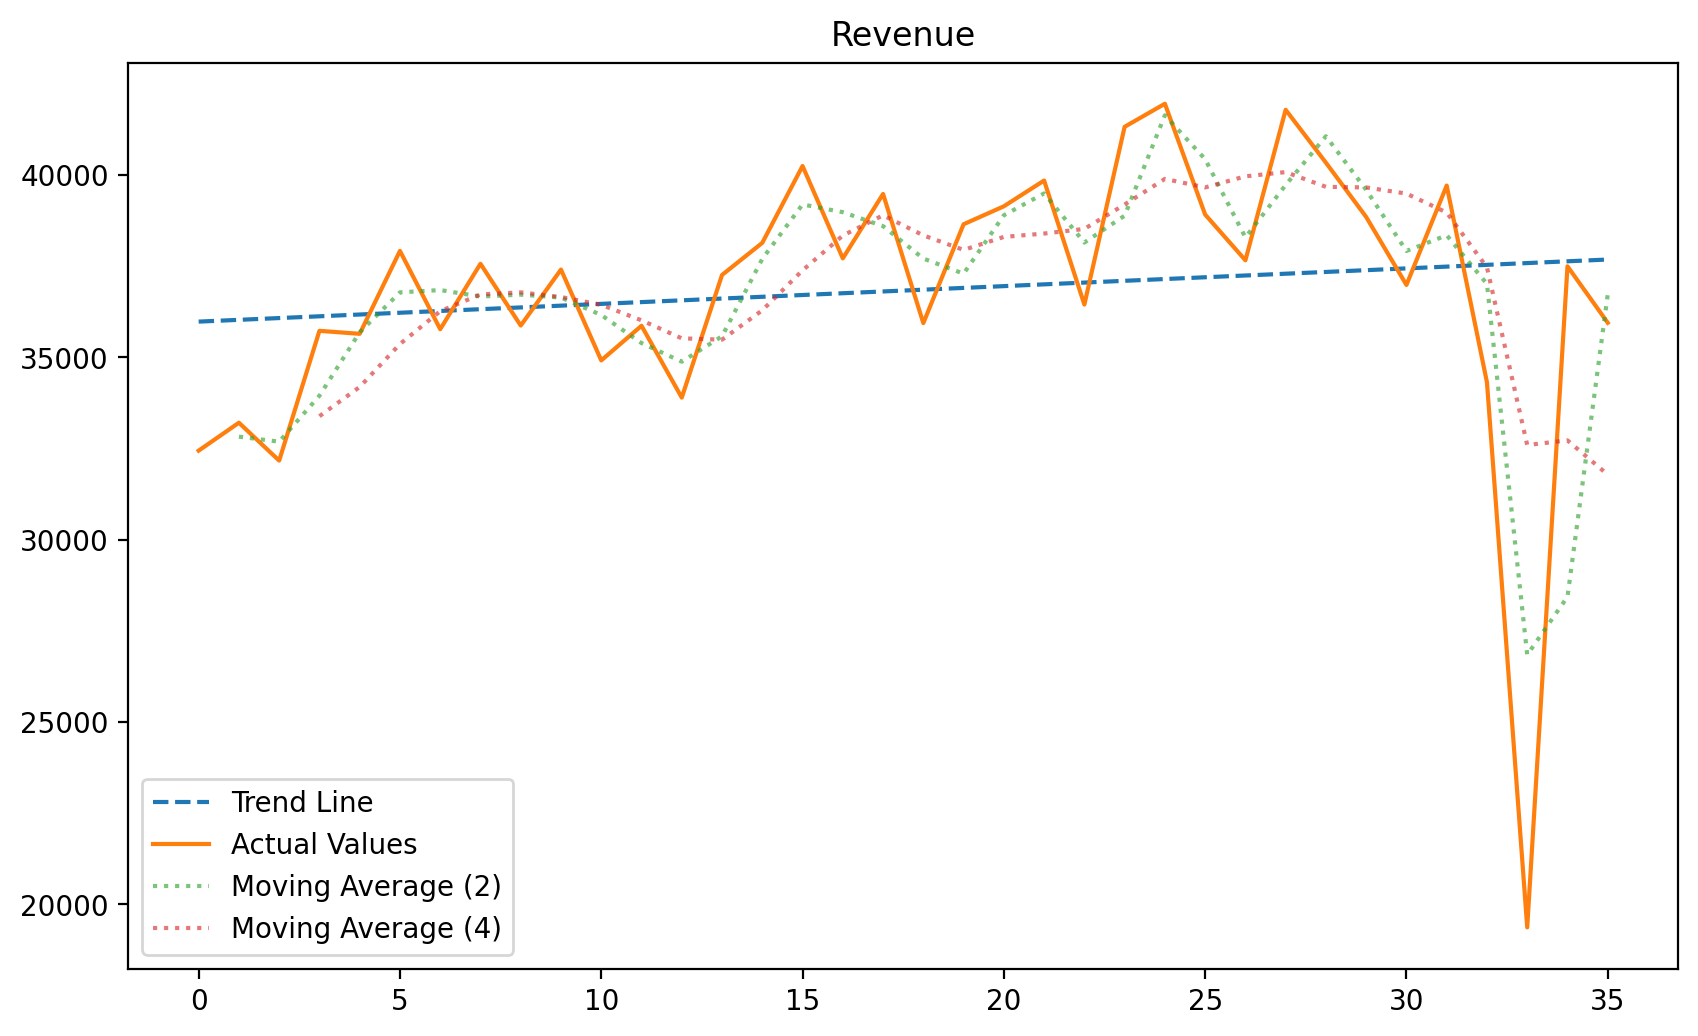

In [5]:
for i in [dataEPS, dataOC, dataProfit, dataRev]:
    z = np.polyfit(np.array(data.index), i.iloc[:,0], 1)
    p = np.poly1d(z)

    fig = plt.figure(figsize= (10, 6), dpi = 200)

    plt.plot(i.index, p(np.array(data.index)), label = "Trend Line", ls = "--")
    plt.plot(i.iloc[:,0], label = "Actual Values")
    plt.plot(i["AvgMean(2)"], label = "Moving Average (2)", linestyle = ":", alpha = 0.618)
    plt.plot(i["AvgMean(4)"], label = "Moving Average (4)", linestyle = ":", alpha = 0.618)
    plt.title(i.columns[0])
    plt.legend()

    print("""Trend Line Equation for {name}:\t{eq} """.format(
        name = i.columns[0], eq = f'{round(p[1], 2)}x + {round(p[0], 2)}'))

# Code for Seasonality Decompresion

In [6]:
data['timestamps'] = data[''].str.replace(r'(Q\d) (\d+)', r'\2-\1', regex = True)
data['timestamps'] = pd.PeriodIndex(data.timestamps, freq = 'Q').to_timestamp()

In [7]:
for i in [dataEPS, dataOC, dataProfit, dataRev]:
    i.set_index(data.timestamps, inplace = True)

<Figure size 1000x600 with 0 Axes>

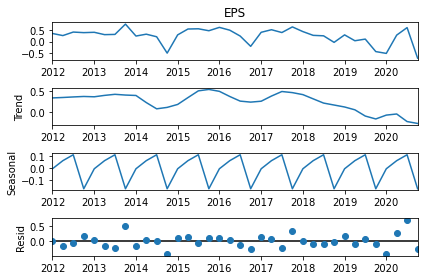

<Figure size 1000x600 with 0 Axes>

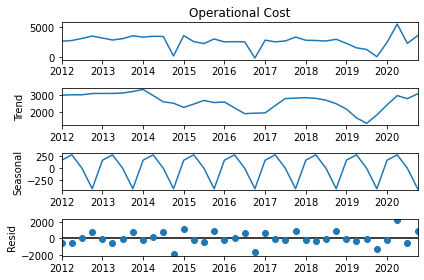

<Figure size 1000x600 with 0 Axes>

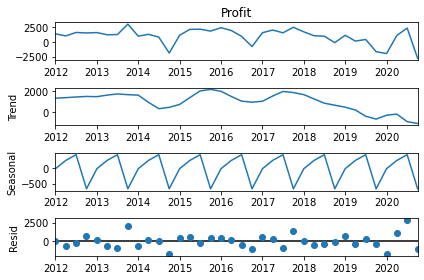

<Figure size 1000x600 with 0 Axes>

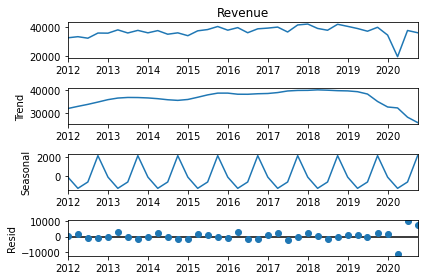

In [8]:
for i in [dataEPS, dataOC, dataProfit, dataRev]:
    #additiveModel
    result_add = seasonal_decompose(i.iloc[:,0], model = 'additive', extrapolate_trend= 'freq')
    
    #addValues to the DataFrames:
    i["Trend"] = result_add.trend
    i["Seasonal"] = result_add.seasonal
    i["Residuals"] = result_add.resid

    #Plots
    fig = plt.figure(figsize = (10, 6), dpi = 100)
    result_add.plot()

# SARIMA

In [9]:
import pmdarima as pm

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[4] intercept   : AIC=29.158, Time=0.45 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=40.457, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=28.099, Time=0.35 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=28.965, Time=0.11 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=38.962, Time=0.00 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=40.274, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[4] intercept   : AIC=29.581, Time=0.13 sec
 ARIMA(1,0,0)(1,1,1)[4] intercept   : AIC=29.336, Time=0.13 sec
 ARIMA(1,0,0)(0,1,1)[4] intercept   : AIC=29.901, Time=0.10 sec
 ARIMA(1,0,0)(2,1,1)[4] intercept   : AIC=31.336, Time=0.24 sec
 ARIMA(0,0,0)(1,1,0)[4] intercept   : AIC=28.187, Time=0.05 sec
 ARIMA(2,0,0)(1,1,0)[4] intercept   : AIC=28.687, Time=0.10 sec
 ARIMA(1,0,1)(1,1,0)[4] intercept   : AIC=27.550, Time=0.13 sec
 ARIMA(1,0,1)(0,1,0)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,0,1)(2,1,0)[4] intercept   : AIC=29.020, Time=0.23 sec


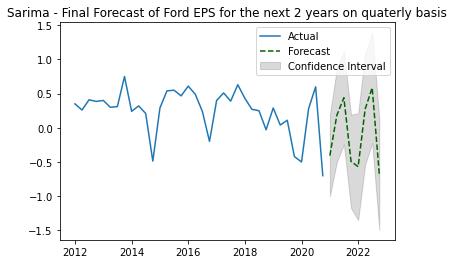

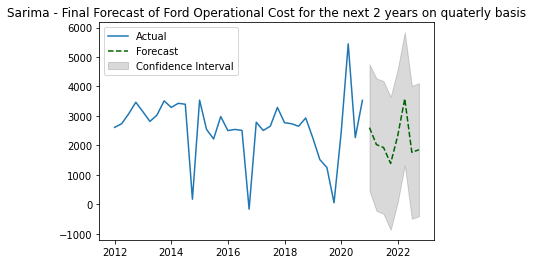

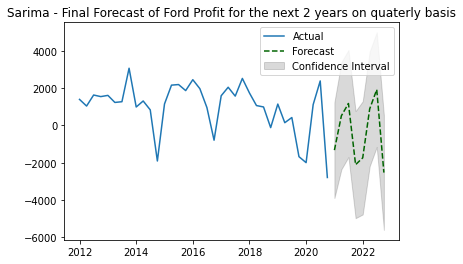

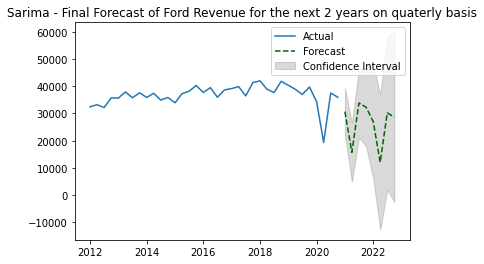

In [10]:
for i, z in zip([dataEPS, dataOC, dataProfit, dataRev], [1, 2, 3, 4]):
    #modelAlignment
    smodel = pm.auto_arima(i.iloc[:,0], start_p = 1, start_q = 1, test= 'adf',
 max_p = 4, max_q = 4, m = 4, start_P= 0, seasonal = True, d= None, D= 1,
 trace = True, error_action = 'ignore', suppress_warnings = True, stepwise = True)
    print(smodel.summary())

    #Model Fit
    n_periods = int(24/3)
    fitted, confint = smodel.predict(n_periods= n_periods, return_conf_int= True)
    index_of_fc = pd.date_range(i.index[-1], periods = n_periods, freq = 'Q')

    fitted_series = pd.Series(fitted, index = index_of_fc)
    lower_series = pd.Series(confint[:,0], index = index_of_fc)
    upper_series = pd.Series(confint[:,1], index = index_of_fc)

    #DataFrame to concat to the main df
    df = pd.DataFrame(data = {'Fitted' : fitted_series, 'LowerBound' : lower_series, 'UpperBound' : upper_series}, index = index_of_fc)
    i = pd.concat([i, df], axis = 1)
   
    #Plot
    plt.figure(z)
    plt.plot(i.iloc[:,0], label = 'Actual')
    plt.plot(fitted_series, color= 'darkgreen', label = 'Forecast', ls= '--')
    plt.fill_between(lower_series.index, lower_series,upper_series, color= 'k', alpha = 0.15, label = 'Confidence Interval')

    plt.legend()
    plt.title(f"Sarima - Final Forecast of Ford {i.columns[0]} for the next 2 years on quaterly basis")
